In [29]:
import os
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import torch
import torch.nn.functional as F
from datasets import Dataset
from hydra import compose, initialize
from omegaconf import OmegaConf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from src.seed import seed_everything
from torch import nn
from torch.utils.data import DataLoader
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

warnings.filterwarnings("ignore")


with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


bert:
  params:
    model_path: microsoft/deberta-v3-large
    metric: auc
    target_col_class_num: 2
    max_length: 192
    fp16: true
    learning_rate: 2.0e-05
    epochs: 3
    per_device_train_batch_size: 8
    per_device_eval_batch_size: 16
    steps: 50
    lr_scheduler_type: cosine
    weight_decay: 0.01
exp_number: '012'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  cloth_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/012/base
seed: 42
n_splits: 5
target: Recommended IND



### exp011をベースに下記変更
- Title, Review Text以外Age, Class Name, Positive Feedback Countのカラムも使用
- learning_rateを1e-5 --> 2e-5に変更
- stepsを25 --> 50に変更
- Smooth Focal Lossを使用 --> smoothing=0にする（smoothing=0.1はあまり効果がなかったと思う）
  - https://www.kaggle.com/c/nbme-score-clinical-patient-notes/discussion/322799#1781528 を参考に実装

### データの準備


In [2]:
train_df = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
test_df = pl.read_csv(cfg.data.test_path, try_parse_dates=True)
cloth_df = pl.read_csv(cfg.data.cloth_path, try_parse_dates=True)

train_df = train_df.join(cloth_df, on="Clothing ID", how="left")
test_df = test_df.join(cloth_df, on="Clothing ID", how="left")

skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)


In [3]:
train_df.head()


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
i64,i64,str,str,i64,i64,i64,str,str,str
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts"""
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts"""
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts"""
0,45,null,"""I was really pleased with this…",5,1,9,"""General""","""Bottoms""","""Skirts"""
0,57,"""Unique, pretty asymmetric skir…","""I saw this skirt in retailer s…",5,1,1,"""General""","""Bottoms""","""Skirts"""


In [4]:
DEBUG = False

if DEBUG:
    train_df = train_df.head(1000)


def preprocess_text(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
        pl.concat_str(
            [
                pl.col("Age").fill_null("none"),
                pl.lit("-Year-Old's Review of "),
                pl.col("Class Name").fill_null("none"),
                pl.lit(" [SEP] "),
                pl.lit("TITLE: "),
                pl.col("Title").fill_null("none"),
                pl.lit(" [SEP] "),
                pl.lit("Review Text: "),
                pl.col("Review Text").fill_null("none"),
                pl.lit(" [SEP] "),
                pl.lit("Positive Feedback Count: "),
                pl.col("Positive Feedback Count").fill_null("none"),
            ]
        ).alias("prompt")
    )
    return df


train_df = preprocess_text(train_df)
test_df = preprocess_text(test_df)

train_df = train_df.with_columns(pl.col(cfg.target).cast(pl.Int8).alias("labels"))


In [5]:
# prompt例
train_df["prompt"][0]


"25-Year-Old's Review of Skirts [SEP] TITLE: 3-season skirt! [SEP] Review Text: Adorable, well-made skirt! lined and very slimming. i had to size up b/c it runs a bit snug around the waist. however, it's worth it b/c this will match many long and short sleeve tops! [SEP] Positive Feedback Count: 4"

In [6]:
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.bert.params.model_path)


def tokenize(sample):
    return tokenizer(sample["prompt"], max_length=cfg.bert.params.max_length, truncation=True)


In [7]:
# token長を確認 --> max_length 192で耐えてる
print(
    f"train_df: {train_df.select(pl.col('prompt').map_elements(lambda x: len(tokenizer(x)['input_ids']))).max().item()}"
)
print(
    f"test_df: {test_df.select(pl.col('prompt').map_elements(lambda x: len(tokenizer(x)['input_ids']))).max().item()}"
)


train_df: 185
test_df: 184


### Smoth Focal Loss


In [8]:
class FocalLoss(nn.Module):
    def __init__(self, reduction="none", alpha=1, gamma=2):
        super().__init__()
        self.reduction = reduction
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1.0 - pt) ** self.gamma * bce_loss
        if self.reduction == "none":
            loss = loss
        elif self.reduction == "sum":
            loss = loss.sum()
        elif self.reduction == "mean":
            loss = loss.mean()
        return loss


class SmoothFocalLoss(nn.Module):
    def __init__(self, reduction="mean", alpha=1, gamma=2, smoothing=0.0):
        super().__init__()
        self.reduction = reduction
        self.focal_loss = FocalLoss(reduction="none", alpha=alpha, gamma=gamma)
        self.smoothing = smoothing

    @staticmethod
    def _smooth(targets: torch.Tensor, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothFocalLoss._smooth(targets, self.smoothing)
        loss = self.focal_loss(inputs, targets)
        if self.reduction == "none":
            loss = loss
        elif self.reduction == "sum":
            loss = loss.sum()
        elif self.reduction == "mean":
            loss = loss.mean()
        return loss


In [9]:
class CustomTrainer(Trainer):
    def __init__(self, loss_fn=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_fn is None:
            loss = F.cross_entropy(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            # ロジットとラベルの形状を調整
            logits = logits[:, 1]  # ポジティブクラスのロジットのみを使用
            labels = labels.float()
            loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


# Smooth Focal Lossのインスタンスを作成
loss_fn = SmoothFocalLoss(alpha=1, gamma=2, smoothing=0)  # 結局gammaしか効かしてない


### 学習

In [10]:
# metricをAUCに変更
def compute_metrics(p):
    preds, labels = p
    preds = torch.softmax(torch.tensor(preds), dim=1).numpy()
    score = roc_auc_score(labels, preds[:, 1])
    return {"auc": score}


# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

y_train = train_df[cfg.target].to_numpy()
oof = np.zeros(len(y_train))

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, y_train)):
    ds_train = Dataset.from_pandas(train_df[train_idx][["prompt", "labels"]].clone().to_pandas())
    ds_val = Dataset.from_pandas(train_df[val_idx][["prompt", "labels"]].clone().to_pandas())

    config = AutoConfig.from_pretrained(cfg.bert.params.model_path)
    model = AutoModelForSequenceClassification.from_pretrained(cfg.bert.params.model_path, config=config)

    ds_train = ds_train.map(tokenize).remove_columns("prompt")
    ds_val = ds_val.map(tokenize).remove_columns("prompt")

    output_dir = os.path.join(cfg.data.results_dir, f"fold{fold}")

    train_args = TrainingArguments(
        output_dir=output_dir,
        fp16=cfg.bert.params.fp16,
        learning_rate=cfg.bert.params.learning_rate,
        num_train_epochs=cfg.bert.params.epochs,
        per_device_train_batch_size=cfg.bert.params.per_device_train_batch_size,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        gradient_accumulation_steps=4,
        report_to="none",
        evaluation_strategy="steps",
        do_eval=True,
        eval_steps=cfg.bert.params.steps,
        save_total_limit=1,
        save_strategy="steps",
        save_steps=cfg.bert.params.steps,
        logging_steps=cfg.bert.params.steps,
        load_best_model_at_end=True,
        lr_scheduler_type=cfg.bert.params.lr_scheduler_type,
        metric_for_best_model=cfg.bert.params.metric,
        greater_is_better=True,
        warmup_ratio=0.1,
        weight_decay=cfg.bert.params.weight_decay,
        save_safetensors=True,
        seed=cfg.seed,
        data_seed=cfg.seed,
    )

    trainer = CustomTrainer(
        model=model,
        args=train_args,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        loss_fn=loss_fn,
    )

    trainer.train()

    final_output_dir = f"{cfg.data.results_dir}/fold{fold}/final"
    trainer.save_model(final_output_dir)
    tokenizer.save_pretrained(final_output_dir)

    pred = torch.softmax(torch.tensor(trainer.predict(ds_val).predictions), dim=1).numpy()
    oof[val_idx] = pred[:, 1]


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.154400,0.115337,0.777087
100,0.075600,0.081926,0.918364
150,0.056300,0.049485,0.966710
200,0.056600,0.058839,0.967298
250,0.052600,0.046742,0.971510
300,0.041300,0.043498,0.973031
350,0.033000,0.050944,0.970073
400,0.038400,0.038271,0.975470
450,0.041600,0.042089,0.975527
500,0.047400,0.038747,0.976048


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.154200,0.110153,0.872783
100,0.075400,0.056047,0.961213
150,0.063400,0.050880,0.966813
200,0.053300,0.049276,0.973198
250,0.047700,0.047934,0.969970
300,0.044200,0.042629,0.971142
350,0.038400,0.042911,0.973078
400,0.040600,0.044638,0.972246
450,0.037800,0.045818,0.972880
500,0.032000,0.046240,0.973105


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.157000,0.119721,0.837587
100,0.090300,0.070617,0.953506
150,0.053800,0.049113,0.965335
200,0.053000,0.045548,0.970678
250,0.043000,0.058293,0.972276
300,0.041900,0.052848,0.970879
350,0.034300,0.051571,0.972210
400,0.040500,0.049375,0.972243
450,0.043500,0.047532,0.972232
500,0.034300,0.049739,0.973452


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.157100,0.105030,0.901187
100,0.101000,0.109009,0.870957
150,0.063000,0.081631,0.961422
200,0.063800,0.060162,0.962331
250,0.055500,0.049807,0.964394
300,0.037300,0.061504,0.965343
350,0.043300,0.048685,0.964286
400,0.031800,0.048261,0.968398
450,0.039700,0.051036,0.971054
500,0.041900,0.051569,0.968262


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.152900,0.116163,0.906015
100,0.072100,0.073576,0.951883
150,0.061500,0.056677,0.966788
200,0.059700,0.049377,0.971109
250,0.053300,0.044699,0.973168
300,0.040000,0.051533,0.971184
350,0.037800,0.046075,0.970277
400,0.040400,0.048181,0.971187
450,0.041800,0.045491,0.972457
500,0.041600,0.053808,0.971773


### Sub


In [11]:
preds = []
for fold in range(cfg.n_splits):
    # ベストステップのモデルを取得
    fold_dir = f"{cfg.data.results_dir}/fold{fold}"
    checkpoint_dirs = [d for d in os.listdir(fold_dir) if d.startswith("checkpoint-")]
    results_dir = os.path.join(fold_dir, checkpoint_dirs[0])
    model = AutoModelForSequenceClassification.from_pretrained(results_dir)

    ds_test = Dataset.from_pandas(test_df.select("prompt").clone().to_pandas())
    ds_test = ds_test.map(tokenize).remove_columns("prompt")

    test_args = TrainingArguments(
        output_dir=cfg.data.results_dir,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        do_predict=True,
        dataloader_drop_last=False,
    )

    trainer = Trainer(
        model=model,
        args=test_args,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
    )
    predictions = torch.softmax(torch.tensor(trainer.predict(ds_test).predictions), dim=1).numpy()
    preds.append(predictions[:, 1])

pred = np.mean(preds, axis=0)


Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

In [12]:
# 提出
sub_df = pl.read_csv(cfg.data.sample_submission_path)
sub_df = sub_df.with_columns(pl.Series(pred).alias("target"))
sub_df.write_csv(os.path.join(cfg.data.results_dir, f"{cfg.run_name}_submission.csv"))
sub_df.head()


target
f32
0.905986
0.486497
0.907969
0.329067
0.89087


### oof


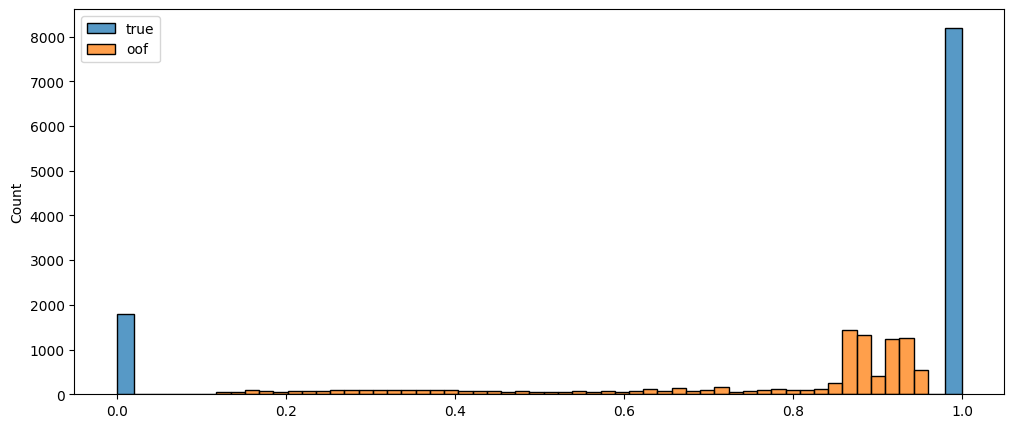

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


In [14]:
# OOFを保存
np.save(f"{cfg.data.results_dir}/oof.npy", oof)

# 予測結果も保存
np.save(f"{cfg.data.results_dir}/pred.npy", pred)


### 学習済みのBERTを使って特徴抽出してみる

In [43]:
# trainのoofで特徴抽出

cfg.run_name = "20240830_164022"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")


# モデルの定義を変更して特徴量を抽出するクラス
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, **inputs):
        outputs = self.model(**inputs, output_hidden_states=True)
        # 最後の隠れ層の出力を取得（他の層を使用することも可能）
        features = outputs.hidden_states[-1][:, 0, :]  # [CLS]トークンの出力を使用
        return features


# 特徴量抽出用の関数
def extract_features(model, dataset, tokenizer):
    feature_extractor = FeatureExtractor(model).to(device)
    feature_extractor.eval()

    features = []
    for batch in DataLoader(dataset, batch_size=8, collate_fn=DataCollatorWithPadding(tokenizer)):
        with torch.no_grad():
            batch = {k: v.to(model.device) for k, v in batch.items()}
            output = feature_extractor(**batch)
            features.append(output.cpu().numpy())

    return np.vstack(features)


# OOFデータの特徴量を抽出
train_oof_features = []
for fold in range(cfg.n_splits):
    fold_dir = f"{cfg.data.results_dir}/fold{fold}"
    checkpoint_dirs = [d for d in os.listdir(fold_dir) if d.startswith("checkpoint-")]
    results_dir = os.path.join(fold_dir, checkpoint_dirs[0])
    model = AutoModelForSequenceClassification.from_pretrained(results_dir)

    # バリデーションデータセットの準備
    val_idx = list(skf.split(train_df, y_train))[fold][1]
    ds_val = Dataset.from_pandas(train_df[val_idx][["prompt"]].clone().to_pandas())
    ds_val = ds_val.map(tokenize).remove_columns("prompt")

    # 特徴量抽出
    fold_features = extract_features(model, ds_val, tokenizer)
    train_oof_features.append(fold_features)


# 全てのフォールドの特徴量を結合
train_oof_features = np.concatenate(train_oof_features, axis=0)


使用デバイス: cuda


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [54]:
print(f"{train_oof_features.shape = }")
# 保存
np.save(f"{cfg.data.results_dir}/train_oof_features.npy", train_oof_features)


train_oof_features.shape = (10000, 1024)


In [55]:
# 次はtestの特徴抽出（fold間での平均を使用する）
test_features = []
for fold in range(cfg.n_splits):
    fold_dir = f"{cfg.data.results_dir}/fold{fold}"
    checkpoint_dirs = [d for d in os.listdir(fold_dir) if d.startswith("checkpoint-")]
    results_dir = os.path.join(fold_dir, checkpoint_dirs[0])
    model = AutoModelForSequenceClassification.from_pretrained(results_dir)

    ds_test = Dataset.from_pandas(test_df.select("prompt").clone().to_pandas())
    ds_test = ds_test.map(tokenize).remove_columns("prompt")

    # 特徴量抽出
    fold_features = extract_features(model, ds_test, tokenizer)
    test_features.append(fold_features)


# 全てのフォールドの特徴量の平均をとる
test_features = np.mean(test_features, axis=0)



Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

In [56]:
print(f"{test_features.shape = }")
# 保存
np.save(f"{cfg.data.results_dir}/test_features.npy", test_features)


test_features.shape = (11155, 1024)
